In [100]:
# ABHINAV VATSA
# ASTR 400B
# I would like to acknowledge the help I got from my friends in terms of doing this assignment since my code broke dozens of times initially.
# Special thanks to Christian for pointing out vital errors in my functions.

#Importing the necessary modules
import numpy as np
import astropy.units as u
from astropy.constants import G
import matplotlib.pyplot as plt

# Import external functions for reading data and computing the center of mass
from ReadFile import Read
from CenterOfMass import CenterOfMass

class MassProfile:
    """
    A class to compute the mass distribution and circular velocity profiles of a galaxy 
    from simulation data. This includes calculating the enclosed mass for different 
    galaxy components (halo, disk, bulge) and deriving the circular velocity profiles.
    
    Attributes
    ----------
    galaxy : str
        Name of the galaxy ('MW', 'M31', or 'M33').
    filename : str
        The formatted filename of the galaxy snapshot.
    time : float
        The time of the snapshot in Myr.
    total : int
        The total number of particles in the snapshot.
    data : np.ndarray
        Structured array containing particle data (positions, velocities, masses, etc.).
    positions : astropy.units.Quantity
        Array of (x, y, z) positions of particles in kpc.
    masses : astropy.units.Quantity
        Array of particle masses in Msun.
    com_pos : astropy.units.Quantity
        Center of mass position vector [x, y, z] in kpc.
    G : astropy.units.Quantity
        Gravitational constant in kpc (km/s)^2 / Msun.
    """
    def __init__(self, galaxy: str, snap: int):
        """
        Initializes the MassProfile instance by loading the snapshot data and 
        calculating the center of mass using the disk particles.

        Parameters
        ----------
        galaxy : str
            The name of the galaxy ('MW', 'M31', or 'M33').
        snap : int
            The snapshot number (e.g., 0 for the current epoch).
        """

        self.galaxy = galaxy
        self.filename = f"{galaxy}_{snap:03d}.txt"

        # Load snapshot data
        self.time, self.total, self.data = Read(self.filename)

        # Extract particle properties with appropriate units
        self.positions = np.vstack([self.data['x'], self.data['y'], self.data['z']]).T * u.kpc
        self.masses = self.data['m'] * 1e10 * u.Msun  # Convert mass units to Msun
        self.type = self.data['type']  # Ensure type attribute is set

        # Compute center of mass using disk particles (ptype=2)
        com = CenterOfMass(self.filename, 2)
        self.com_pos = com.COM_P(0.1)  # Returns [x_COM, y_COM, z_COM] in kpc

        # Gravitational constant in kpc (km/s)^2 / Msun
        self.G = G.to(u.kpc * u.km**2 / (u.s**2 * u.Msun))
        
    def mass_enclosed(self, ptype, radii):
        """
        Computes the mass enclosed within a specified radius for a given particle type.

        Parameters
        ----------
        ptype : int
            The particle type (e.g., 1 for halo, 2 for disk, 3 for bulge).
        radii : array-like
            An array of radii (in kpc) at which to calculate the enclosed mass.

        Returns
        -------
        np.ndarray
            An array of enclosed masses (in Msun) at the specified radii.
        """

        # Select particles of the given type
        index = np.where(self.type == ptype)

        # Extract mass and positions of selected particles
        m_selected = self.masses[index]  # Msun
        x_selected = self.positions[index, 0]  # kpc
        y_selected = self.positions[index, 1]  # kpc
        pos_selected = self.positions[index]  # Extract full position array
        


        # Compute distance from the center
        r_selected = np.linalg.norm(pos_selected - self.com_pos, axis=1)  # Compute radii relative to COM
        
        # Sort particles by radius
        sorted_index = np.argsort(r_selected)
        r_sorted = r_selected[sorted_index]
        m_sorted = m_selected[sorted_index]

        # Compute cumulative sum of mass
        m_enc = np.cumsum(m_sorted)

        # Interpolate to get mass at requested radii
        # Ensure radii is an astropy Quantity with units of kpc
        radii = np.asarray(radii) * u.kpc

        return np.interp(radii.to_value(u.kpc), r_sorted.to_value(u.kpc), m_enc.to_value(u.Msun)) * u.Msun


    def mass_enclosed_total(self, radii):
        """
        Calculates the total enclosed mass within a given radius by summing the contributions 
        from the halo, disk, and bulge components.

        Parameters
        ----------
        radii : array-like
            An array of radii (in kpc) at which to compute the total enclosed mass.

        Returns
        -------
        np.ndarray
            An array of total enclosed masses (in Msun) at the specified radii.
        """

        # Compute enclosed mass for each component
        m_halo = self.mass_enclosed(1, radii)
        m_disk = self.mass_enclosed(2, radii)

        # Bulge (only present in MW and M31, not in M33)
        if self.galaxy == 'M33':  
            m_bulge = 0 * m_halo  # Ensures correct array shape
        else:
            m_bulge = self.mass_enclosed(3, radii)
    
        return m_halo + m_disk + m_bulge


    def HernquistMass(self, r, a, Mhalo):
        """
        Computes the Hernquist 1990 mass profile, defined as:
        M(r) = Mhalo * (r^2 / (r + a)^2)
        
        Parameters
        ----------
        r : float or np.ndarray
            The radius (in kpc) at which to compute the enclosed mass.
        a : float
            The scale radius (in kpc) that defines the profile shape.
        Mhalo : float
            The total halo mass (in Msun).
        
        Returns
        -------
        M_hern : astropy.units.Quantity
            The enclosed mass at the specified radius (in Msun).
        """

        r_kpc = r * u.kpc
        a_kpc = a * u.kpc
        Mhalo_msun = Mhalo * u.Msun
        
        frac = (r_kpc**2) / (r_kpc + a_kpc)**2
        M_hern = Mhalo_msun * frac
        return M_hern


    def circular_velocity(self, ptype, radii):
        """
        Computes the circular velocity for the specified component at each radius in 
        the provided 'radii', where the velocity is given by:
        V_circ(r) = sqrt(G * M_enclosed(r) / r)
        
        Parameters
        ----------
        ptype : int
            The particle type (1 for Halo, 2 for Disk, 3 for Bulge).
        radii : np.ndarray
            An array of radii (in kpc) at which to calculate the circular velocity.
        
        Returns
        -------
        V_circ : astropy.units.Quantity
            The circular velocity (in km/s), rounded to two decimal places.
        """

        # Enclosed mass
        Menc = self.mass_enclosed(ptype, radii)  # Msun
        r_kpc = radii * u.kpc
        
        V_circ = np.sqrt(self.G * Menc / r_kpc)
        return np.round(V_circ, 2)


    def circular_velocity_total(self, radii):
        """
        Computes the total circular velocity (halo + disk + bulge) at each radius in the 
        provided 'radii', where the total velocity is given by:
        V_circ_total(r) = sqrt(G * [M_halo + M_disk + M_bulge] / r)
        
        Parameters
        ----------
        radii : array-like
            An array of radii (in kpc) at which to calculate the total circular velocity.
        
        Returns
        -------
        V_circ_total : astropy.units.Quantity
            The total circular velocity (in km/s), rounded to two decimal places.
        """

        Mtot = self.mass_enclosed_total(radii)  # Msun
        r_kpc = radii * u.kpc
        
        V_circ = np.sqrt(self.G * Mtot / r_kpc)
        return np.round(V_circ, 2)


    def hernquist_circular_velocity(self, r, a, Mhalo):
        """
        Computes the circular velocity for a Hernquist halo, where the mass profile is given by:
        M(r) = Mhalo * (r^2 / (r + a)^2),
        and the circular velocity is:
        V_circ(r) = sqrt(G * M(r) / r).
        
        Parameters
        ----------
        r : float or array-like
            The radius (in kpc) at which to compute the circular velocity.
        a : float
            The scale radius (in kpc) of the Hernquist profile.
        Mhalo : float
            The total halo mass (in Msun).
        
        Returns
        -------
        V_hern : astropy.units.Quantity
            The circular velocity of the Hernquist halo (in km/s), rounded to two decimal places.
        """

        r_kpc = r * u.kpc
        a_kpc = a * u.kpc
        Mhalo_msun = Mhalo * u.Msun
        
        # M(r) for Hernquist
        M_hern = Mhalo_msun * (r_kpc**2 / (r_kpc + a_kpc)**2)
        
        V_hern = np.sqrt(self.G * M_hern / r_kpc)
        return np.round(V_hern, 2)

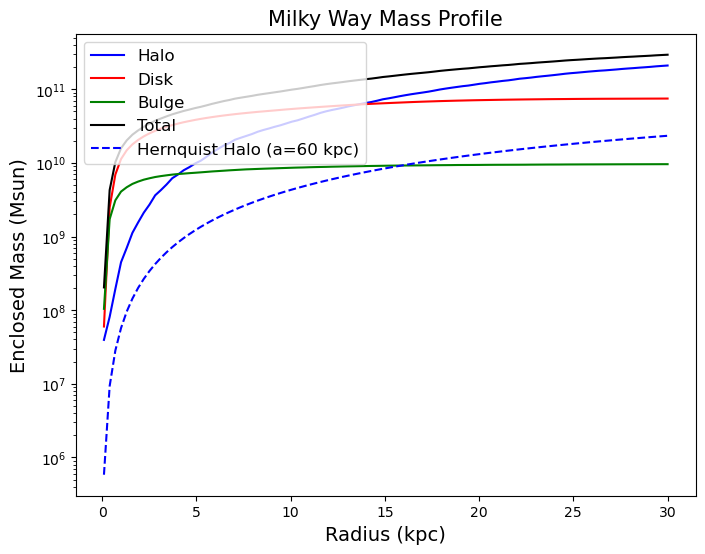

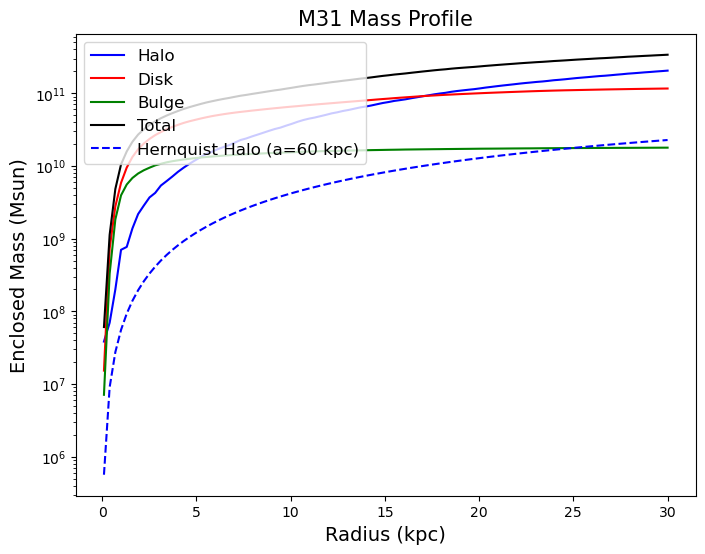

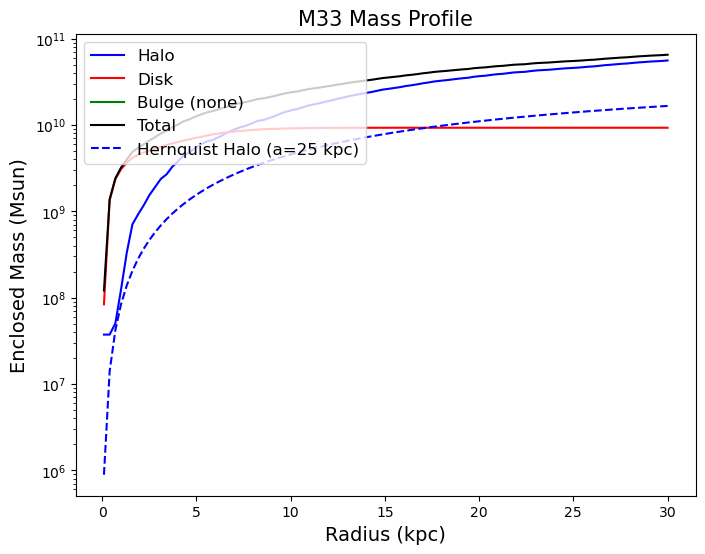

In [94]:
# ------------------------------------------------------------------------------
# Initialize MassProfile Objects for Each Galaxy
# ------------------------------------------------------------------------------
MW = MassProfile("MW", 0)
M31 = MassProfile("M31", 0)
M33 = MassProfile("M33", 0)

# Define an array of radii from 0.1 to 30 kpc (as a plain numpy array).
r = np.linspace(0.1, 30, 100)  # units: kpc

# ------------------------------------------------------------------------------
# Milky Way (MW) Mass Profile Calculation and Visualization
# ------------------------------------------------------------------------------
M_halo_MW = MW.mass_enclosed(1, r)
M_disk_MW = MW.mass_enclosed(2, r)
M_bulge_MW = MW.mass_enclosed(3, r)  # MW has a bulge
M_total_MW = MW.mass_enclosed_total(r)

# Extract scalar halo mass at the outermost radius for Hernquist model normalization.
MW_halo_mass = M_halo_MW[-1].value  
a_guess_MW = 60  # scale radius guess in kpc
M_hern_MW = MW.HernquistMass(r, a_guess_MW, MW_halo_mass)

plt.figure(figsize=(8, 6))
plt.semilogy(r, M_halo_MW.value, color='b', label='Halo')
plt.semilogy(r, M_disk_MW.value, color='r', label='Disk')
plt.semilogy(r, M_bulge_MW.value, color='g', label='Bulge')
plt.semilogy(r, M_total_MW.value, color='k', label='Total')
plt.semilogy(r, M_hern_MW.value, 'b--', label=f'Hernquist Halo (a={a_guess_MW} kpc)')

plt.title('Milky Way Mass Profile', fontsize=15)
plt.xlabel('Radius (kpc)', fontsize=14)
plt.ylabel('Enclosed Mass (Msun)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.savefig("1_Mass_Profile_Milky_Way.png", dpi=300, bbox_inches="tight")
plt.show()

# ------------------------------------------------------------------------------
# Andromeda (M31) Mass Profile Calculation and Visualization
# ------------------------------------------------------------------------------
M_halo_M31 = M31.mass_enclosed(1, r)
M_disk_M31 = M31.mass_enclosed(2, r)
M_bulge_M31 = M31.mass_enclosed(3, r)  # M31 has a bulge
M_total_M31 = M31.mass_enclosed_total(r)

M31_halo_mass = M_halo_M31[-1].value  
a_guess_M31 = 60  # scale radius guess in kpc
M_hern_M31 = M31.HernquistMass(r, a_guess_M31, M31_halo_mass)

plt.figure(figsize=(8, 6))
plt.semilogy(r, M_halo_M31.value, color='b', label='Halo')
plt.semilogy(r, M_disk_M31.value, color='r', label='Disk')
plt.semilogy(r, M_bulge_M31.value, color='g', label='Bulge')
plt.semilogy(r, M_total_M31.value, color='k', label='Total')
plt.semilogy(r, M_hern_M31.value, 'b--', label=f'Hernquist Halo (a={a_guess_M31} kpc)')

plt.title('M31 Mass Profile', fontsize=15)
plt.xlabel('Radius (kpc)', fontsize=14)
plt.ylabel('Enclosed Mass (Msun)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.savefig("2_Mass_Profile_M31.png", dpi=300, bbox_inches="tight")
plt.show()

# ------------------------------------------------------------------------------
# Triangulum (M33) Mass Profile Calculation and Visualization
# ------------------------------------------------------------------------------
M_halo_M33 = M33.mass_enclosed(1, r)
M_disk_M33 = M33.mass_enclosed(2, r)
# M33 has no bulge; create an array of zeros with the same shape as M_halo_M33.
M_bulge_M33 = np.zeros_like(M_halo_M33.value) * u.Msun  
M_total_M33 = M33.mass_enclosed_total(r)

M33_halo_mass = M_halo_M33[-1].value  
a_guess_M33 = 25  # scale radius guess in kpc
M_hern_M33 = M33.HernquistMass(r, a_guess_M33, M33_halo_mass)

plt.figure(figsize=(8, 6))
plt.semilogy(r, M_halo_M33.value, color='b', label='Halo')
plt.semilogy(r, M_disk_M33.value, color='r', label='Disk')
plt.semilogy(r, M_bulge_M33.value, color='g', label='Bulge (none)')
plt.semilogy(r, M_total_M33.value, color='k', label='Total')
plt.semilogy(r, M_hern_M33.value, 'b--', label=f'Hernquist Halo (a={a_guess_M33} kpc)')

plt.title('M33 Mass Profile', fontsize=15)
plt.xlabel('Radius (kpc)', fontsize=14)
plt.ylabel('Enclosed Mass (Msun)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.savefig("3_Mass_Profile_M33.png", dpi=300, bbox_inches="tight")
plt.show()


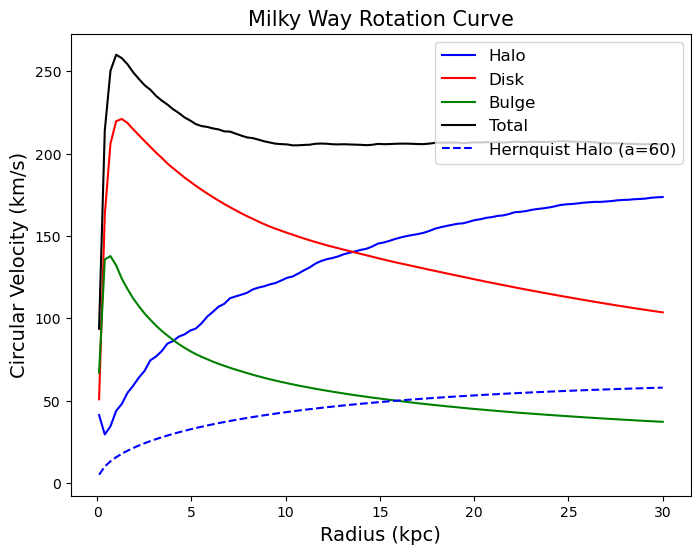

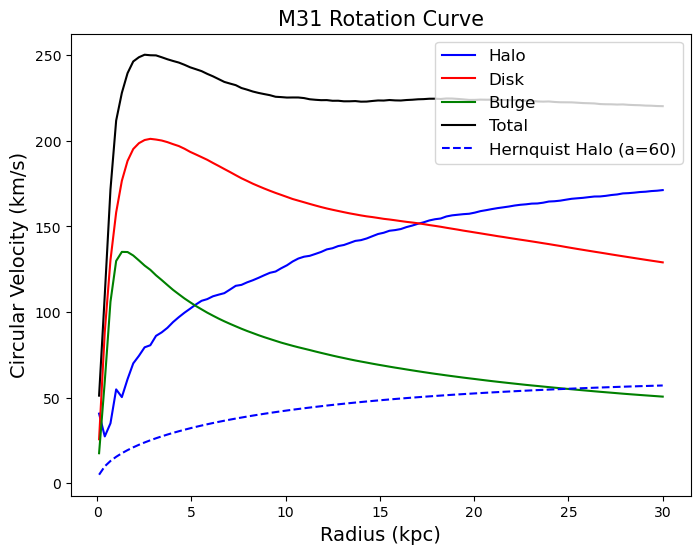

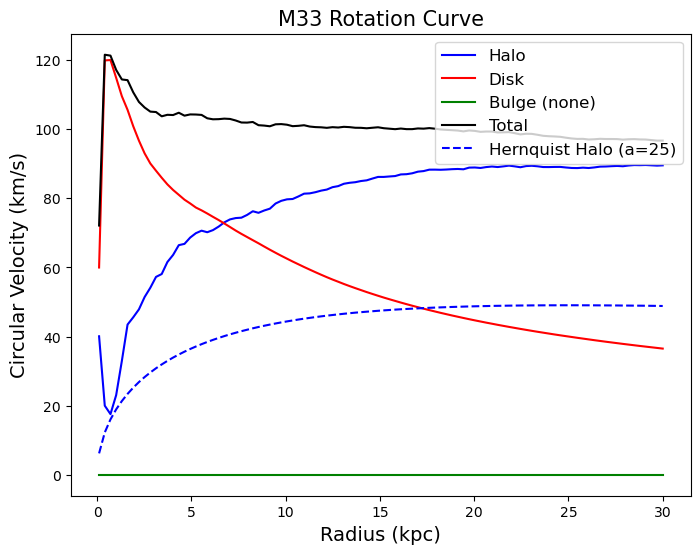

In [96]:
# ------------------------------------------------------------------------------
# Define Radii Array for Rotation Curves
# ------------------------------------------------------------------------------
# Define an array of radii (in kpc) from 0.1 to 30. These radii will be used
# to calculate the rotation curves for each galaxy.
r_circ = np.linspace(0.1, 30, 100)  # kpc

# ------------------------------------------------------------------------------
# Milky Way Rotation Curve
# ------------------------------------------------------------------------------
# For the Milky Way (MW), we compute the circular velocity curves for each 
# galaxy component (halo, disk, bulge) and the total rotation curve.
#
# Parameters:
#   r_circ: np.ndarray
#       Array of radii in kpc where the rotation velocities are calculated.
#
# Outputs:
#   Vhalo_MW, Vdisk_MW, Vbulge_MW: astropy.units.Quantity
#       Circular velocities for the halo, disk, and bulge components (km/s).
#   Vtotal_MW: astropy.units.Quantity
#       Total circular velocity combining all components (km/s).
#   VC_hern_MW: astropy.units.Quantity
#       Circular velocity from the Hernquist model for the halo (km/s).
#
# Note: The halo mass and scale radius guesses (a_guess_MW) are reused from the
# previously computed mass profile.
Vhalo_MW = MW.circular_velocity(1, r_circ)
Vdisk_MW = MW.circular_velocity(2, r_circ)
Vbulge_MW = MW.circular_velocity(3, r_circ)
Vtotal_MW = MW.circular_velocity_total(r_circ)
VC_hern_MW = MW.hernquist_circular_velocity(r_circ, a_guess_MW, MW_halo_mass)

# Plotting the Milky Way rotation curve
plt.figure(figsize=(8, 6))
plt.plot(r_circ, Vhalo_MW, 'b', label='Halo')
plt.plot(r_circ, Vdisk_MW, 'r', label='Disk')
plt.plot(r_circ, Vbulge_MW, 'g', label='Bulge')
plt.plot(r_circ, Vtotal_MW, 'k', label='Total')
plt.plot(r_circ, VC_hern_MW, 'b--', label=f'Hernquist Halo (a={a_guess_MW})')

plt.title('Milky Way Rotation Curve', fontsize=15)
plt.xlabel('Radius (kpc)', fontsize=14)
plt.ylabel('Circular Velocity (km/s)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.savefig("4_Rotation_Curve_Milky_Way.png", dpi=300, bbox_inches="tight")
plt.show()

# ------------------------------------------------------------------------------
# M31 Rotation Curve
# ------------------------------------------------------------------------------
# For Andromeda (M31), compute the rotation curves for the halo, disk, and bulge,
# as well as the total rotation curve and the Hernquist model-based halo curve.
#
# Parameters and Outputs are analogous to the Milky Way section.
Vhalo_M31 = M31.circular_velocity(1, r_circ)
Vdisk_M31 = M31.circular_velocity(2, r_circ)
Vbulge_M31 = M31.circular_velocity(3, r_circ)
Vtotal_M31 = M31.circular_velocity_total(r_circ)
VC_hern_M31 = M31.hernquist_circular_velocity(r_circ, a_guess_M31, M31_halo_mass)

# Plotting the M31 rotation curve
plt.figure(figsize=(8, 6))
plt.plot(r_circ, Vhalo_M31, 'b', label='Halo')
plt.plot(r_circ, Vdisk_M31, 'r', label='Disk')
plt.plot(r_circ, Vbulge_M31, 'g', label='Bulge')
plt.plot(r_circ, Vtotal_M31, 'k', label='Total')
plt.plot(r_circ, VC_hern_M31, 'b--', label=f'Hernquist Halo (a={a_guess_M31})')

plt.title('M31 Rotation Curve', fontsize=15)
plt.xlabel('Radius (kpc)', fontsize=14)
plt.ylabel('Circular Velocity (km/s)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.savefig("5_Rotation_Curve_M31.png", dpi=300, bbox_inches="tight")
plt.show()

# ------------------------------------------------------------------------------
# M33 Rotation Curve
# ------------------------------------------------------------------------------
# For the Triangulum galaxy (M33), the bulge component is absent. Thus, the 
# bulge circular velocity is set to zero. Compute and plot the rotation curves 
# for the halo, disk, and total components, and the Hernquist model for the halo.
#
# Parameters and Outputs are analogous to the previous sections, with special
# handling for the bulge (set to zero).
Vhalo_M33 = M33.circular_velocity(1, r_circ)
Vdisk_M33 = M33.circular_velocity(2, r_circ)
Vbulge_M33 = 0.0 * Vhalo_M33  # No bulge for M33
Vtotal_M33 = M33.circular_velocity_total(r_circ)
VC_hern_M33 = M33.hernquist_circular_velocity(r_circ, a_guess_M33, M33_halo_mass)

# Plotting the M33 rotation curve
plt.figure(figsize=(8, 6))
plt.plot(r_circ, Vhalo_M33, 'b', label='Halo')
plt.plot(r_circ, Vdisk_M33, 'r', label='Disk')
plt.plot(r_circ, Vbulge_M33, 'g', label='Bulge (none)')
plt.plot(r_circ, Vtotal_M33, 'k', label='Total')
plt.plot(r_circ, VC_hern_M33, 'b--', label=f'Hernquist Halo (a={a_guess_M33})')

plt.title('M33 Rotation Curve', fontsize=15)
plt.xlabel('Radius (kpc)', fontsize=14)
plt.ylabel('Circular Velocity (km/s)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.savefig("6_Rotation_Curve_M33.png", dpi=300, bbox_inches="tight")
plt.show()


This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'config_template.ipynb' matched no files
